## **Text Feature Engineering and Modelling**
Done by Wong Wen Bing 230436M

In [338]:
# pip install scikit-learn seaborn 

In [339]:
import nltk
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [340]:
df=pd.read_csv('230436M_cleaned_data.csv')
df.head()

,Unnamed: 0,description,species,text_length,cleaned_text,chunked,POS Tag
0,0,2 Jun 2023 ï¿½ The Javan myna shares some simi...,Javan Myna,162,jun javan myna share similarity common myna te...,jun javan_myna share similarity common myna te...,"[[('jun', 'NN'), ('javan_myna', 'NN'), ('share..."
1,1,Click here for more information about the Red ...,Collared Kingfisher,398,click information red list category criterion ...,click information red list category criterion ...,"[[('click', 'JJ'), ('information', 'NN'), ('re..."
2,2,The black-headed oriole ( Oriolus larvatus) is...,Black-naped Oriole,349,black headed oriole oriolus larvatus specie bi...,black_headed_oriole oriolus larvatus specie bi...,"[[('black_headed_oriole', 'JJ'), ('oriolus', '..."
3,3,"Search from thousands of royalty-free ""Javan M...",Javan Myna,177,search thousand royalty free javan myna stock ...,search thousand royalty free javan_myna stock ...,"[[('search', 'NN'), ('thousand', 'CD'), ('roya..."
4,4,521 foreground recordings and 156 background ...,Little Egret,112,foreground recording background recording egre...,foreground recording background recording egre...,"[[('foreground', 'NN'), ('recording', 'VBG'), ..."


#### **Feature Engineering**   
There are different types of features that can be done, we will be using a mix of vectorizers as comparison. A base model will be trained to examine this.




In [342]:
X = df['chunked']
Y=df['species']

Setting test size and training size

In [344]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

Using Count Vectorizer with N-Grams of 2

In [346]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(stop_words='english', ngram_range=(1,2))
X_train_cv=cv.fit_transform(X_train)
X_test_cv=cv.transform(X_test) #make sure X_test is TRANSFORM and not fit_transform

#print dimensions and features 
print(f"""
training: {X_train_cv.toarray().shape}
test: {X_test_cv.toarray().shape}

features: {cv.get_feature_names_out()}
      """)


training: (488, 9705)
test: (123, 9705)

features: ['aa' 'aa sitesettingsid' 'ability' ... 'zimbabwe zambia' 'zoonosis'
 'zoonosis singapore']
      


Using Tfifdf Vectorizer with N-grams of 2

In [349]:
from sklearn.feature_extraction.text import TfidfVectorizer
tv=TfidfVectorizer(stop_words='english', ngram_range=(1,2))
X_train_tv=tv.fit_transform(X_train)
X_test_tv=tv.transform(X_test) #make sure X_test is TRANSFORM and not fit_transform

#print dimensions and features 
print(f"""
training: {X_train_tv.toarray().shape}
test: {X_test_tv.toarray().shape}

features: {tv.get_feature_names_out()}
      """)


training: (488, 9705)
test: (123, 9705)

features: ['aa' 'aa sitesettingsid' 'ability' ... 'zimbabwe zambia' 'zoonosis'
 'zoonosis singapore']
      


Trying something different with Top N words feature

In [351]:
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from wordcloud import WordCloud
txt=df['chunked'].tolist() #convert dataframe columns to list
txt=' '.join(txt)
# print(txt)

<FreqDist with 3392 samples and 14479 outcomes>


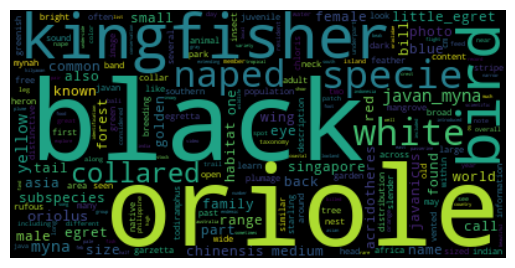

In [352]:
freq_dist=FreqDist(txt.split()) #calculate frequency of words that should be a list
print(freq_dist)
cloud=WordCloud().generate_from_frequencies(freq_dist) #generate word cloud
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [353]:
print(len(freq_dist))

3392


Given that there are 3391 records, let's use the top 2000 most relevants words

In [355]:
top2k_words=freq_dist.most_common(500)

In [356]:
def lissttt(string): 
    strings=[]
    x=string.split(' ')
    return x
df['text']=df['chunked'].apply(lambda x:lissttt(x))

Write a function to create a feature set to train the classifier. A feature extractor function is defined that checks if the words in a given document are present in the top2k words feature.

In [358]:
# Enter code here
def document_features(df, stemmed_tokens):
    doc_features = []
    for index, row in df.iterrows():
        features = {}
        for word in top2k_words:
            # get term occurence: true if it's in the word_features, false if it's not
            features[word] = (word in row[stemmed_tokens])
        doc_features.append(features)
    return doc_features

feature_set = pd.DataFrame(document_features(df, 'text'), index = df.index)
feature_set.head()

from sklearn.model_selection import train_test_split

X=feature_set
y=df[df.columns[2]]
print(y)
X_train_doc, X_test_doc, y_train_doc, y_test_doc= train_test_split(X, y, test_size=0.2, random_state=42)

0               Javan Myna
1      Collared Kingfisher
2       Black-naped Oriole
3               Javan Myna
4             Little Egret
              ...         
606     Black-naped Oriole
607    Collared Kingfisher
608           Little Egret
609     Black-naped Oriole
610           Little Egret
Name: species, Length: 611, dtype: object


In [359]:
## understanding feature importance

##### **Usage of A Base Model for testing**
We will use a base model, Logistic Regression to decide which of the vectorizers or bag of words features can produce the most results. T

In [361]:
from sklearn.linear_model import LogisticRegression

#train
def vectorise_data(X_train_cv,X_test_cv):
    lr=LogisticRegression(solver='lbfgs')
    lr.fit(X_train_cv, y_train)
    y_pred_cv=lr.predict(X_test_cv)
    accuracy=accuracy_score(y_test, y_pred_cv)
    return accuracy

print(f'''
Vectorizer: Count Vectorizer
Accuracy: {vectorise_data(X_train_cv, X_test_cv)} 
=================================================================================================

Vectorizer: Tfidf Vectorizer
Accuracy: {vectorise_data(X_train_tv, X_test_cv)}

=================================================================================================

Vectorizer: Top N words feature
Accuracy: {vectorise_data(X_train_doc, X_test_doc)}

''')



Vectorizer: Count Vectorizer
Accuracy: 0.926829268292683 

Vectorizer: Tfidf Vectorizer
Accuracy: 0.943089430894309


Vectorizer: Top N words feature
Accuracy: 0.3170731707317073




In [362]:
import pickle
with open('TFifdf Vectorizer.pkl', 'wb') as f1: 
    pickle.dump(tv, f1)

Based on the above models process, we can conclude that the tfidf vectorizer has a higher accuracy rate, and hence it is used. We now save the vectorizer for usage in the testing set.

#### **Modelling**
There will be a number of models tested.

1. Logistic Regression
2. Naives Bayes
3. Support Vector Machine

In [364]:
#importing different models 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.linear_model import SGDClassifier

#accuracy metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


#list of models
models=[
    {'name': 'Logistic Regression', 
     'model': LogisticRegression(solver='lbfgs')}, 
    {'name': 'Naive Bayes (Multinomial)', 
     'model': MultinomialNB()}, 
    {'name': 'Support Vector Machine', 
     'model': svm.LinearSVC()}, 
    {'name': 'Linear Support Vector Machine', 
     'model': SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)}
]
results=[]

#printing confusion matrix    
def conf_matrix(y_test, pred_test):    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(4), range(4))
    #Ploting the confusion matrix
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    

In [387]:
#run models and print classificaton report
from sklearn.metrics import accuracy_score
used_model= []
for modell in models:
    model=modell['model']
    model.fit(X_train_tv, y_train)
    y_pred_cv=model.predict(X_test_tv)
    accuracy=accuracy_score(y_test, y_pred_cv)
    class_report=classification_report(y_test, y_pred_cv, target_names=['Black-naped Oriole','Collared Kingfisher','Javan Myna','Little Egret'])
    
    # confusionmatrix = conf_matrix(y_test, y_pred_cv)
    print(f'''
    Model Name: {modell['name']}
    Accuracy: {accuracy:.2f}
    Classification report: 
    {class_report}
    ======================================================================================================
    ''')

    save_model={
        'name': modell['name'], 
        'function': model
    }
    used_model.append(save_model)
    


    Model Name: Logistic Regression
    Accuracy: 0.94
    Classification report: 
                         precision    recall  f1-score   support

 Black-naped Oriole       0.97      0.95      0.96        39
Collared Kingfisher       1.00      0.93      0.96        28
         Javan Myna       0.84      1.00      0.91        32
       Little Egret       1.00      0.88      0.93        24

           accuracy                           0.94       123
          macro avg       0.95      0.94      0.94       123
       weighted avg       0.95      0.94      0.94       123

    

    Model Name: Naive Bayes (Multinomial)
    Accuracy: 0.89
    Classification report: 
                         precision    recall  f1-score   support

 Black-naped Oriole       0.76      1.00      0.87        39
Collared Kingfisher       1.00      0.89      0.94        28
         Javan Myna       0.94      0.91      0.92        32
       Little Egret       1.00      0.67      0.80        24

           accu

### **Model 1: Logistic Regression**

In [367]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
lr=OneVsRestClassifier(LogisticRegression(solver='lbfgs'))

#train
lr.fit(X_train_cv, y_train)

#apply to test
y_pred_cv=lr.predict(X_test_cv)
y_pred_cv

array(['Collared Kingfisher', 'Javan Myna', 'Little Egret', 'Javan Myna',
       'Black-naped Oriole', 'Javan Myna', 'Collared Kingfisher',
       'Javan Myna', 'Javan Myna', 'Black-naped Oriole',
       'Black-naped Oriole', 'Black-naped Oriole', 'Collared Kingfisher',
       'Black-naped Oriole', 'Javan Myna', 'Javan Myna',
       'Collared Kingfisher', 'Black-naped Oriole', 'Little Egret',
       'Javan Myna', 'Little Egret', 'Little Egret', 'Little Egret',
       'Javan Myna', 'Collared Kingfisher', 'Collared Kingfisher',
       'Collared Kingfisher', 'Black-naped Oriole', 'Collared Kingfisher',
       'Black-naped Oriole', 'Collared Kingfisher', 'Javan Myna',
       'Little Egret', 'Little Egret', 'Black-naped Oriole',
       'Little Egret', 'Little Egret', 'Black-naped Oriole',
       'Black-naped Oriole', 'Black-naped Oriole', 'Javan Myna',
       'Little Egret', 'Little Egret', 'Black-naped Oriole',
       'Black-naped Oriole', 'Little Egret', 'Little Egret', 'Javan Myna',
    

In [368]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(123, 4)

In [369]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay
class_of_interest="Little Egret"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_pred_cv[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"One-vs-Rest ROC curves:\{class_of_interest} vs (all)",
)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred_cv)
cm

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_cv, target_names=['Black-naped Oriole','Collared Kingfisher','Javan Myna','Little Egret']))

Saving the model

In [ ]:
import pickle
with open(f'Logistic Regression.pkl', 'wb') as f1: 
    pickle.dump(lr, f1)

### **Model 2: Naives Bayes**

In [ ]:
#MAIN DIFFERENCE IN CODE
from sklearn.naive_bayes import MultinomialNB

nb=MultinomialNB()

#train
nb.fit(X_train_cv, y_train)

#move to X_test
y_pred_cv=nb.predict(X_test_cv)
# y_pred_cv

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred_cv)
cm

In [ ]:
# Function to create a confusion matrix 
def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(4), range(4))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    
#Ploting the confusion matrix
conf_matrix(y_test, y_pred_cv)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_cv, target_names=['Black-naped Oriole','Collared Kingfisher','Javan Myna','Little Egret']))

Support Vector Machine


In [ ]:
from sklearn import svm

supportvector=svm.LinearSVC()
#train
supportvector.fit(X_train_cv, y_train)

#move to X_test
y_pred_cv=supportvector.predict(X_test_cv)

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred_cv)
cm

In [ ]:
from sklearn.metrics import classification_report
svm_results = classification_report(y_test, y_pred_cv, target_names=['Black-naped Oriole','Collared Kingfisher','Javan Myna','Little Egret'])